In [304]:
import pandas as pd
import numpy
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve


# ! pip install statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf


import warnings
warnings.filterwarnings('ignore')

# 1. Data Cleaning

In [305]:
data = pd.read_csv('data.csv')
data.head()

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,BALLS,STRIKES,IS_RUNNER_ON_1B,IS_RUNNER_ON_2B,IS_RUNNER_ON_3B,PITCHER_KEY,THROW_SIDE_KEY,PITCH_TYPE_TRACKED_KEY,EVENT_RESULT_KEY,PITCH_RESULT_KEY,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z
0,197,1,1,1,0,0,0,0,0,0,668881,R,FB,field_out,InPlay,14.54220,-12.36030,2402.459961,100.764999,-2.42717,6.08550,6.46,1.612990,-5.76003,0.197045,1.91282
1,348,1,2,1,1,0,0,0,0,0,668881,R,FB,NaN,BallCalled,14.25380,-10.95030,2273.459961,100.431000,-2.52253,5.97044,6.56,0.631016,-4.60990,-0.943079,2.87744
2,1072,1,2,2,1,1,0,0,0,0,668881,R,SL,single,InPlay,5.56877,4.35335,2314.459961,89.848999,-2.64242,5.89410,6.71,3.330480,-6.76551,0.012025,2.16833
3,420,1,3,1,1,0,0,1,0,0,668881,R,SL,NaN,FoulBall,4.80541,4.27254,2340.459961,89.810997,-2.52429,5.90717,6.55,3.804230,-6.87764,0.584736,2.11319
4,198,1,3,2,1,0,1,1,0,0,668881,R,SL,NaN,BallCalled,4.13239,1.62418,2445.459961,89.014397,-2.68096,6.10905,6.37,2.385210,-5.89879,-0.634335,3.45222


In [306]:
data.shape

(9889, 26)

In [307]:
data.columns

Index(['PID', 'INNING_KEY', 'BATTER_IN_INNING_KEY', 'PITCH_NUMBER', 'OUT_KEY',
       'BALLS', 'STRIKES', 'IS_RUNNER_ON_1B', 'IS_RUNNER_ON_2B',
       'IS_RUNNER_ON_3B', 'PITCHER_KEY', 'THROW_SIDE_KEY',
       'PITCH_TYPE_TRACKED_KEY', 'EVENT_RESULT_KEY', 'PITCH_RESULT_KEY',
       'INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK', 'SPIN_RATE_ABSOLUTE',
       'RELEASE_SPEED', 'RELEASE_SIDE', 'RELEASE_HEIGHT', 'RELEASE_EXTENSION',
       'HORIZONTAL_APPROACH_ANGLE', 'VERTICAL_APPROACH_ANGLE', 'PLATE_X',
       'PLATE_Z'],
      dtype='object')

In [308]:
data.PITCHER_KEY.value_counts()

PITCHER_KEY
668933    1187
671096     776
682227     724
596133     676
668881     516
594902     494
666157     463
571656     434
664747     427
518585     413
664139     401
608371     394
571882     387
622065     334
643361     255
650960     186
570666     184
665665     176
686651     171
674285     148
668984     144
656818     135
594580     106
683175      95
680689      94
611093      91
686730      87
641427      65
592741      42
664028      42
592527      41
621219      40
669270      37
622088      36
691094      34
571912      29
613564      25
Name: count, dtype: int64

In [309]:
data.columns[data.isna().any()]

Index(['EVENT_RESULT_KEY'], dtype='object')

### Data does not have any NA values besides in the column EVENT_RESULT_KEY. Now we attempt to remove outliers or pitches that were not tracked correctly. These will like likely be in the pitch data such as break and spin rate.

In [310]:
data.drop(columns = ['INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK', 'SPIN_RATE_ABSOLUTE','RELEASE_SPEED']).describe()

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,BALLS,STRIKES,IS_RUNNER_ON_1B,IS_RUNNER_ON_2B,IS_RUNNER_ON_3B,PITCHER_KEY,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z
count,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000
mean,12609.406007,5.007786,2.935079,2.878653,0.997674,0.882293,0.874810,0.309839,0.174638,0.102033,637412.410254,-0.668325,5.825911,6.226203,0.768435,-6.415098,0.072584,2.338810
std,7802.242707,2.660815,1.741784,1.714279,0.822356,0.965159,0.822483,0.462451,0.379677,0.302706,44958.635446,1.758907,0.460130,0.561980,2.270130,1.831539,0.822927,0.975443
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,518585.000000,-3.305770,4.330060,3.790000,-8.813830,-13.842500,-3.588650,-1.892670
25%,6004.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,596133.000000,-1.805150,5.659290,5.780000,-0.463435,-7.700000,-0.479877,1.689210
50%,12590.000000,5.000000,3.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,664747.000000,-1.316150,5.835330,6.160000,0.898488,-6.365400,0.073093,2.340190
75%,19511.000000,7.000000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,668933.000000,0.550795,6.109050,6.630000,2.298520,-5.029050,0.621404,3.001330
max,28755.000000,11.000000,14.000000,14.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,691094.000000,4.026390,7.090960,8.040000,7.158210,-1.185400,3.983160,6.079330


In [311]:
data[['INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK', 'SPIN_RATE_ABSOLUTE','RELEASE_SPEED']].describe()

,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,SPIN_RATE_ABSOLUTE,RELEASE_SPEED
count,9889.000000,9889.000000,9889.000000,9889.000000
mean,6.937282,-0.370263,2293.930972,89.144199
std,7.749274,11.163954,377.813504,5.925928
min,-21.982201,-25.363899,524.210999,54.441101
25%,1.593640,-9.955600,2131.350098,84.752502
50%,7.065330,-0.769889,2322.459961,90.093803
75%,13.751000,8.787780,2502.469971,93.820900
max,22.767300,26.991199,3314.679932,102.327003


### First looking at release speed, the max value seems accurate but the minimum value of 54 is likely not valueable for our analysis. This is likely a position player pitching and we would like to remove this from our data.

In [312]:
data.RELEASE_SPEED.mean() - 3*data.RELEASE_SPEED.std()

71.36641531699583

In [313]:
data_velo = data[['INNING_KEY','RELEASE_SPEED']]
data_velo[data_velo.RELEASE_SPEED<71]

,INNING_KEY,RELEASE_SPEED
1398,9,57.449600
1399,9,62.946301
1400,9,54.797100
1401,9,61.536701
1402,9,59.368599
1403,9,62.213600
1404,9,56.644600
1405,9,59.989700
1406,9,61.851299
1407,9,65.429703


### Using the methodology of considering 3 standard deviations less than the mean as outliers, we find this minimum value to be 71. However, there are some curveballs in the MLB that are thrown below 75 mph such as Zack Greinkes eephus, so we would like to include these pitches. If we change the threshold to 68 mph, we only get pitches that were thrown in the 9th inning which will be position players pitching in blowouts

In [314]:
data_cleaned = data[data.RELEASE_SPEED>65]

### For horizontal break, it will be a bit harder to use the three standard deviation method since the data is not normalized for handedness. For this variable, we will keep all observations. 

### For vertical break, these numbers seem reasonable so we keep them as well. 

### Next, look at the different pitch types

In [315]:
data_cleaned.PITCH_TYPE_TRACKED_KEY.value_counts()

PITCH_TYPE_TRACKED_KEY
FB    3272
SW    1716
CF    1307
CH    1198
SL     909
SI     815
CB     469
SF     173
UN       4
Name: count, dtype: int64

In [316]:
data_cleaned = data_cleaned.loc[~data_cleaned['PITCH_TYPE_TRACKED_KEY'].isin(['UN', 'KN'])]

### Get rid of rows that contain unknown pitches and knuckleballs since they arent very common and we cannot gather enough information about them

# 2. Feature Engineering

### For runners on base, knowing which base is occupied is likely not important. We would just like to know if there is anyone on base or if it is bases empty so that we can know if the pitcher is pitching from the stretch or the wind up

In [317]:
data_cleaned['Runner_On'] = data_cleaned.apply(lambda row: 1 if ((row['IS_RUNNER_ON_1B']==1) or (row['IS_RUNNER_ON_2B']==1) or (row['IS_RUNNER_ON_3B']==1)) else 0, axis = 1)

### Create a new categorical variable that represents the count type (Full, 2 strike, ahead, neutral)

In [318]:
def pitch_category(row):
    if ((row['BALLS'] == 3) and (row['STRIKES'] == 2)):
        return "Full"
    elif (((row['BALLS'] == 2) and (row['STRIKES'] == 0)) or ((row['BALLS'] == 3) and (row['STRIKES'] == 0)) or ((row['BALLS'] == 3) and (row['STRIKES'] == 1))) :
        return "Behind"
    elif (((row['BALLS'] == 0) and (row['STRIKES'] == 2)) or ((row['BALLS'] == 1) and (row['STRIKES'] == 2)) or ((row['BALLS'] == 2) and (row['STRIKES'] == 2))):
        return "2-Strikes"
    else:
        return "Neutral"
    
data_cleaned['Pitch_Category'] = data_cleaned.apply(pitch_category,axis = 1)

In [319]:
data_cleaned.drop(columns = ["BALLS","STRIKES","IS_RUNNER_ON_1B","IS_RUNNER_ON_2B","IS_RUNNER_ON_3B"],inplace=True)

In [320]:
data_cleaned.columns

Index(['PID', 'INNING_KEY', 'BATTER_IN_INNING_KEY', 'PITCH_NUMBER', 'OUT_KEY',
       'PITCHER_KEY', 'THROW_SIDE_KEY', 'PITCH_TYPE_TRACKED_KEY',
       'EVENT_RESULT_KEY', 'PITCH_RESULT_KEY', 'INDUCED_VERTICAL_BREAK',
       'HORIZONTAL_BREAK', 'SPIN_RATE_ABSOLUTE', 'RELEASE_SPEED',
       'RELEASE_SIDE', 'RELEASE_HEIGHT', 'RELEASE_EXTENSION',
       'HORIZONTAL_APPROACH_ANGLE', 'VERTICAL_APPROACH_ANGLE', 'PLATE_X',
       'PLATE_Z', 'Runner_On', 'Pitch_Category'],
      dtype='object')

In [321]:
data_cleaned[['PITCH_TYPE_TRACKED_KEY','THROW_SIDE_KEY','HORIZONTAL_BREAK']].tail()

,PITCH_TYPE_TRACKED_KEY,THROW_SIDE_KEY,HORIZONTAL_BREAK
9884,FB,R,-8.54239
9885,CF,R,0.60670
9886,FB,R,-10.84110
9887,CH,R,-13.44000
9888,FB,R,-7.68615


### Normalize Horizontal Break so that a negative value means armside run and a positive value means gloveside cut 

In [322]:
def normalize_horizontal_break(row):
    if row["THROW_SIDE_KEY"] == "L":
        return row["HORIZONTAL_BREAK"] * -1
    else:
        return row["HORIZONTAL_BREAK"]
    
data_cleaned["HORIZONTAL_BREAK_NORMALIZED"] = data_cleaned.apply(normalize_horizontal_break,axis=1)

### Create a new variable that is the difference between mean spin rate grouped by pitcher and pitch type and the actual spin rate value. Also create a variable for std based on the same groupings. Do this for spin rate, induced vertical break, and induced horizontal break. This will tell us how much different a specific pitch's spin rate and movement is compared to normal

In [323]:
# Get mean and std based on the groupings for spin rate and movement variables
mean_and_std = data_cleaned.groupby(['PITCHER_KEY', 'PITCH_TYPE_TRACKED_KEY'])[['SPIN_RATE_ABSOLUTE','INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK_NORMALIZED']].agg(['mean','std']).reset_index()

# label columns as either the _mean or _std of the variables
mean_and_std.columns = ['_'.join(col).strip('_') for col in mean_and_std.columns.values]

# combine these new variables with the rest of the dataset
data_cleaned = data_cleaned.merge(mean_and_std, on=['PITCHER_KEY', 'PITCH_TYPE_TRACKED_KEY'])

# Calculating the difference over the mean spin rate by pitcher and pitch type
data_cleaned['DIFF_MEAN_SPIN_RATE'] = abs(data_cleaned['SPIN_RATE_ABSOLUTE'] - data_cleaned['SPIN_RATE_ABSOLUTE_mean'])

data_cleaned['VERTICAL_BREAK_DIFF'] = abs(data_cleaned['INDUCED_VERTICAL_BREAK'] - data_cleaned['INDUCED_VERTICAL_BREAK_mean'])
data_cleaned['HORIZONTAL_BREAK_DIFF'] = abs(data_cleaned['HORIZONTAL_BREAK_NORMALIZED'] - data_cleaned['HORIZONTAL_BREAK_NORMALIZED_mean'])

# 4. Naive Approach

### The naive approach would be saying that pitches are affected by humidity if if spin rate and movement are either significantly larger or smaller than they typically are.

### To do this, we use DIFF_MEAN_SPIN_RATE, VERTICAL_BREAK_DIFF, and HORIZONTAL_BREAK_DIFF directly to create a probability value. This can be done by normalizing the values by subtracting each value by the min value and dividing by the difference between min and max value. This will give us a value between 0 and 1 for each of the three differences. If we take the average of all 3 values, we can have our newly crated probability variable. This probability will essentially represent how different these three variables that are most likely going to be affected by changes in humidity will be compared to what they normally are for a specific pitcher and specific pitch. For example, if a players spin rate and vertical movement for a specific curveball are very different from what it typically is, there is a good chance that it was affected by humidity.

In [324]:
# Similar to the previous code but for min and max instead of mean and std
min_and_max = data_cleaned.groupby(['PITCHER_KEY', 'PITCH_TYPE_TRACKED_KEY'])[['DIFF_MEAN_SPIN_RATE','VERTICAL_BREAK_DIFF', 'HORIZONTAL_BREAK_DIFF']].agg(['min','max']).reset_index()
min_and_max.columns = ['_'.join(col).strip('_') for col in min_and_max.columns.values]
data_cleaned = data_cleaned.merge(min_and_max, on=['PITCHER_KEY', 'PITCH_TYPE_TRACKED_KEY'])

# normalize all these variables from a 0 - 1 scale
data_cleaned['NORMAlIZED_SPIN_RATE_DIFF'] = (data_cleaned['DIFF_MEAN_SPIN_RATE'] - data_cleaned['DIFF_MEAN_SPIN_RATE_min']) / (data_cleaned['DIFF_MEAN_SPIN_RATE_max'] - data_cleaned['DIFF_MEAN_SPIN_RATE_min']) 

data_cleaned['NORMAlIZED_VERTICAL_BREAK_DIFF'] = (data_cleaned['VERTICAL_BREAK_DIFF'] - data_cleaned['VERTICAL_BREAK_DIFF_min']) / (data_cleaned['VERTICAL_BREAK_DIFF_max'] - data_cleaned['VERTICAL_BREAK_DIFF_min']) 

data_cleaned['NORMAlIZED_HORIZONTAL_BREAK_DIFF'] = (data_cleaned['HORIZONTAL_BREAK_DIFF'] - data_cleaned['HORIZONTAL_BREAK_DIFF_min']) / (data_cleaned['HORIZONTAL_BREAK_DIFF_max'] - data_cleaned['HORIZONTAL_BREAK_DIFF_min']) 


### Calculate the probability by taking the average of the three normalized values. 

In [325]:
data_cleaned['NAIVE_PROBABILITY'] = (data_cleaned['NORMAlIZED_SPIN_RATE_DIFF'] + data_cleaned['NORMAlIZED_VERTICAL_BREAK_DIFF'] + data_cleaned['NORMAlIZED_HORIZONTAL_BREAK_DIFF']) / 3

### Dealing with newly created NAN values

In [326]:
pd.set_option('display.max_columns', None)

rows_with_nan = data_cleaned[data_cleaned['NAIVE_PROBABILITY'].isnull()]
rows_with_nan

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,PITCHER_KEY,THROW_SIDE_KEY,PITCH_TYPE_TRACKED_KEY,EVENT_RESULT_KEY,PITCH_RESULT_KEY,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z,Runner_On,Pitch_Category,HORIZONTAL_BREAK_NORMALIZED,SPIN_RATE_ABSOLUTE_mean,SPIN_RATE_ABSOLUTE_std,INDUCED_VERTICAL_BREAK_mean,INDUCED_VERTICAL_BREAK_std,HORIZONTAL_BREAK_NORMALIZED_mean,HORIZONTAL_BREAK_NORMALIZED_std,DIFF_MEAN_SPIN_RATE,VERTICAL_BREAK_DIFF,HORIZONTAL_BREAK_DIFF,DIFF_MEAN_SPIN_RATE_min,DIFF_MEAN_SPIN_RATE_max,VERTICAL_BREAK_DIFF_min,VERTICAL_BREAK_DIFF_max,HORIZONTAL_BREAK_DIFF_min,HORIZONTAL_BREAK_DIFF_max,NORMAlIZED_SPIN_RATE_DIFF,NORMAlIZED_VERTICAL_BREAK_DIFF,NORMAlIZED_HORIZONTAL_BREAK_DIFF,NAIVE_PROBABILITY
5438,1738,8,4,3,2,643361,R,SI,strikeout,StrikeSwinging,15.96230,-15.788900,2120.899902,92.843002,-1.607160,6.10625,5.67,-1.010580,-6.14681,-1.157810,1.854620,1,2-Strikes,-15.788900,2120.899902,NaN,15.962300,NaN,-15.788900,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
7377,12682,8,3,4,2,641427,R,CH,NaN,BallCalled,7.92106,-18.730700,2110.100098,91.809601,-0.724565,5.92240,5.92,-0.966362,-8.35778,0.020209,0.322395,0,Neutral,-18.730700,2108.525024,2.227490,7.018345,1.276632,-17.692650,1.468024,1.575073,0.902715,1.038050,1.575073,1.575073,0.902715,0.902715,1.038050,1.038050,NaN,NaN,NaN,NaN
7378,4129,9,1,7,0,641427,R,CH,NaN,FoulBall,6.11563,-16.654600,2106.949951,90.122902,-0.936305,6.06368,5.70,-1.053520,-6.75765,-0.463233,2.212750,0,2-Strikes,-16.654600,2108.525024,2.227490,7.018345,1.276632,-17.692650,1.468024,1.575073,0.902715,1.038050,1.575073,1.575073,0.902715,0.902715,1.038050,1.038050,NaN,NaN,NaN,NaN
9417,19825,9,1,3,0,641427,R,SW,field_out,InPlay,-7.02980,13.920000,2525.939941,83.925003,-0.987840,5.80727,5.99,2.468780,-8.50733,0.078926,1.960830,0,Neutral,13.920000,2509.439941,23.334524,-1.996015,7.118847,12.196350,2.437609,16.500000,5.033785,1.723650,16.500000,16.500000,5.033785,5.033785,1.723650,1.723650,NaN,NaN,NaN,NaN
9418,21997,9,3,1,1,641427,R,SW,NaN,BallCalled,3.03777,10.472700,2492.939941,84.512199,-0.915519,5.84557,5.81,3.212230,-6.71708,1.155490,2.747550,1,Neutral,10.472700,2509.439941,23.334524,-1.996015,7.118847,12.196350,2.437609,16.500000,5.033785,1.723650,16.500000,16.500000,5.033785,5.033785,1.723650,1.723650,NaN,NaN,NaN,NaN
9419,19672,9,3,2,1,641427,R,SI,NaN,BallCalled,7.94368,-17.512600,2166.939941,94.890404,-0.953574,5.75293,5.78,-1.977690,-6.47390,-1.256940,1.753820,1,Neutral,-17.512600,2173.939941,9.899495,7.107110,1.183088,-18.308450,1.125502,7.000000,0.836570,0.795850,7.000000,7.000000,0.836570,0.836570,0.795850,0.795850,NaN,0.0,0.0,NaN
9420,21998,9,3,4,1,641427,R,SI,NaN,StrikeCalled,6.27054,-19.104300,2180.939941,94.771301,-0.895021,5.78927,5.87,-1.681130,-6.68075,-0.773764,1.776320,1,Neutral,-19.104300,2173.939941,9.899495,7.107110,1.183088,-18.308450,1.125502,7.000000,0.836570,0.795850,7.000000,7.000000,0.836570,0.836570,0.795850,0.795850,NaN,1.0,1.0,NaN
9624,21759,9,1,1,0,664028,R,SL,NaN,BallCalled,-0.20714,0.735015,2324.830078,83.498596,-2.267210,5.68314,6.29,1.664220,-5.40111,-0.797570,4.134010,0,Neutral,0.735015,2320.830078,5.656854,-0.071350,0.192036,0.349186,0.545645,4.000000,0.135790,0.385829,4.000000,4.000000,0.135790,0.135790,0.385829,0.385829,NaN,NaN,1.0,NaN
9625,20259,9,2,1,0,664028,R,SL,NaN,BallCalled,0.06444,-0.036643,2316.830078,82.646202,-2.109260,5.67473,6.16,-0.770084,-3.30852,-2.817410,6.079330,0,Neutral,-0.036643,2320.830078,5.656854,-0.071350,0.192036,0.349186,0.545645,4.000000,0.135790,0.385829,4.000000,4.000000,0.135790,0.135790,0.385829,0.385829,NaN,NaN,0.0,NaN
9642,17917,5,2,1,1,592527,R,CB,NaN,BallCalled,-12.49830,8.805330,2415.820068,74.972099,-1.923770,6.45299,5.56,2.286080,-8.56409,-0.560044,3.904600,0,Neutral,8.805330,2420.820068,7.071068,-12.111300,0.547300,7.325710,2

### Based on the above section of the dataframe, we can see that rows containing NAN for the naive probability are instances when a pitcher has only has one or two pitches of a specific type captured in the data. If the pitch is thrown once, the difference values such as VERTICAL_BREAK_DIFF will be zero and there will be zeroes in the denominator of the normalization equation. If a pitch is thrown only twice, the mean value for all measurements will be between the two values and therefore the difference between each value and the mean will be the same. This will cause the min and max for that specfic difference to be 0 and there will be zeroes in the denominator again. 

### Since we cannot get much information about pitches thrown so rarely, and there are a small amount of instances of this occuring, we can impute zero for the probabilities of these rows.

In [327]:
data_cleaned['NAIVE_PROBABILITY'].fillna(0, inplace=True)

# 5. Define Target Variable

### We will define a pitch affected by humidity if it has spin rate that is more than one standard deviation less or greater than than the mean. We include pitches one standard deviation less because less spin rate means the pitcher does not have a good grip on the ball. This loss of grip can be attributted to humidity/the ball being slippery. We include pitches one standard deviation greater than the mean because when the air is humid, the air density is lower and therefore it allows spin rates to be faster according to this article: https://sabr.org/journal/article/how-climate-change-will-affect-baseball/

### This one standard deviation value is arbitrary but since around 68% of data falls within 1 standard deviation of the mean, this gives us a relatively balanced dataset to work with. 

In [328]:
data_cleaned['DEWPOINT_AFFECTED'] = (abs(data_cleaned['DIFF_MEAN_SPIN_RATE']) > data_cleaned['SPIN_RATE_ABSOLUTE_std']).astype(int)
data_cleaned['DEWPOINT_AFFECTED'].value_counts(normalize=True)

DEWPOINT_AFFECTED
0    0.706157
1    0.293843
Name: proportion, dtype: float64

### As mentioned, the dataset is relatively balanced with 70% not being affected by humidity and 30% being affected. 

# 6. We can now test the accuracy of our naive method compared to our newly created DEWPOINT_AFFECTED variable

In [329]:
data_cleaned['NAIVE_PREDICTION'] = data_cleaned['NAIVE_PROBABILITY'].apply(lambda x: 1 if x>0.4 else 0)

In [330]:
data_cleaned['NAIVE_PREDICTION'].value_counts(normalize=True)

NAIVE_PREDICTION
0    0.829293
1    0.170707
Name: proportion, dtype: float64

In [331]:
accuracy_score(data_cleaned['NAIVE_PREDICTION'],data_cleaned['DEWPOINT_AFFECTED'])

0.748047469317375

### Accuracy score is not a great way to evaluate any model we choose since the data is imbalanced

### I imagine that the next steps of a project like this would be to see which pitchers are affected most by humidity. This would help with important decisions such as lining up the rotation so pitchers who do worse in humidity do not have to pitch in those conditions or making sure that rookies who are affected by humidity are not called up to pitch in conditions where they are less likely to succeed since that will negatively impact their confidence. In this case it is better to be safe than sorry, so we would like as many pitches as possible that are actually affected by humidity to be classified as such. In this case Recall would be more important and we would not care about false positives as much. 

### Another next step would be to determine which pitchers struggle in humid conditions in order to help them make adjustments. In this case, we would want to keep false positives low so that we only try to help pitchers who actually need it since making too many adjustments to a pitcher may be problematic. In this case, we would prioritize Precision


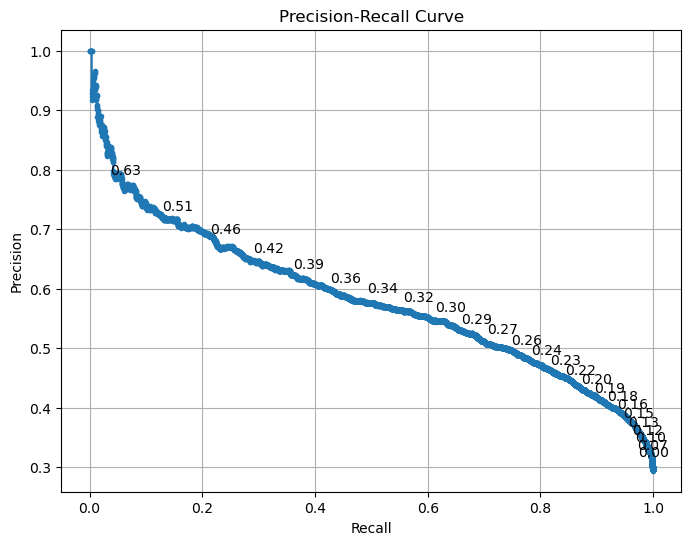

In [332]:
def precision_recall_graph(y_actual,y_probs):
    precision, recall, thresholds = precision_recall_curve(y_actual,y_probs)
    indices_to_annotate = np.arange(0, len(thresholds), 400)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    
    
    # Annotating the points
    for i in indices_to_annotate:
        plt.annotate(f"{thresholds[i]:.2f}", (recall[i], precision[i]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.show()


precision_recall_graph(data_cleaned['DEWPOINT_AFFECTED'],data_cleaned['NAIVE_PROBABILITY'])

### Using the above plot, we can choose the threshold for our Naive Probability variable based on if we prefer Recall or Precision

# 7. Initial Feature Selection For Modeling

In [343]:
data_cleaned.columns

Index(['PID', 'INNING_KEY', 'BATTER_IN_INNING_KEY', 'PITCH_NUMBER', 'OUT_KEY',
       'PITCHER_KEY', 'THROW_SIDE_KEY', 'PITCH_TYPE_TRACKED_KEY',
       'EVENT_RESULT_KEY', 'PITCH_RESULT_KEY', 'INDUCED_VERTICAL_BREAK',
       'HORIZONTAL_BREAK', 'SPIN_RATE_ABSOLUTE', 'RELEASE_SPEED',
       'RELEASE_SIDE', 'RELEASE_HEIGHT', 'RELEASE_EXTENSION',
       'HORIZONTAL_APPROACH_ANGLE', 'VERTICAL_APPROACH_ANGLE', 'PLATE_X',
       'PLATE_Z', 'Runner_On', 'Pitch_Category', 'HORIZONTAL_BREAK_NORMALIZED',
       'SPIN_RATE_ABSOLUTE_mean', 'SPIN_RATE_ABSOLUTE_std',
       'INDUCED_VERTICAL_BREAK_mean', 'INDUCED_VERTICAL_BREAK_std',
       'HORIZONTAL_BREAK_NORMALIZED_mean', 'HORIZONTAL_BREAK_NORMALIZED_std',
       'DIFF_MEAN_SPIN_RATE', 'VERTICAL_BREAK_DIFF', 'HORIZONTAL_BREAK_DIFF',
       'DIFF_MEAN_SPIN_RATE_min', 'DIFF_MEAN_SPIN_RATE_max',
       'VERTICAL_BREAK_DIFF_min', 'VERTICAL_BREAK_DIFF_max',
       'HORIZONTAL_BREAK_DIFF_min', 'HORIZONTAL_BREAK_DIFF_max',
       'NORMAlIZED_SPIN_RATE_

### Ideally here we would have pitcher fatigue to use as a feature. INNING_KEY could possibly be used but in the later innings we do not know if the pitcher is a starter pitching deep into the game or a relief pitcher, so it would be best not to include it. 

### BATTER_IN_INNING_KEY could show pitcher fatigue so we opt to include it, the same can be said for PITCH_NUMBER

### OUT_KEY can be converted to categorical and included

### PITCHER_KEY and PITCH_TYPE_TRACKED_KEY are important since they tell a lot about what the pitch characterstics should be. 

### The remaining variables below can be tested to see which are valuable for predictions

In [344]:
X_all = data_cleaned[['BATTER_IN_INNING_KEY', 'PITCH_NUMBER', 'OUT_KEY', 'PITCHER_KEY', 'THROW_SIDE_KEY', 'PITCH_TYPE_TRACKED_KEY',
                      'PITCH_RESULT_KEY', 'RELEASE_SPEED','RELEASE_SIDE', 'RELEASE_HEIGHT', 'RELEASE_EXTENSION','HORIZONTAL_APPROACH_ANGLE', 'VERTICAL_APPROACH_ANGLE', 'PLATE_X',
                      'PLATE_Z', 'Runner_On', 'Pitch_Category', 'VERTICAL_BREAK_DIFF','HORIZONTAL_BREAK_DIFF']]

y_naive = data_cleaned['NAIVE_PREDICTION']
y = data_cleaned['DEWPOINT_AFFECTED']

# 8. Encode and Standardize the Data, then run RandomForestClassifier for feature importance

In [345]:
numeric_features = ['BATTER_IN_INNING_KEY', 'PITCH_NUMBER', 'RELEASE_SPEED', 'RELEASE_HEIGHT', 'RELEASE_EXTENSION','HORIZONTAL_APPROACH_ANGLE', 'VERTICAL_APPROACH_ANGLE', 'PLATE_X',
                    'PLATE_Z']

categorical_features = ['OUT_KEY','PITCHER_KEY','THROW_SIDE_KEY', 'PITCH_TYPE_TRACKED_KEY', 'PITCH_RESULT_KEY','RELEASE_SIDE','Runner_On', 'Pitch_Category']

# make sure the features we want to be categorical are string data types
for col in categorical_features:
    X_all[col] = X_all[col].astype(str)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.3, random_state=42)

# create the transformer pipeline that uses StandardScaler to standardize the numeric variables and uses one hot encoding
# to encode the categorical variables 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)    

# Create a pipeline with preprocessor and a RandomForest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf)])

# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['BATTER_IN_INNING_KEY',
                                                   'PITCH_NUMBER',
                                                   'RELEASE_SPEED',
                                                   'RELEASE_HEIGHT',
                                                   'RELEASE_EXTENSION',
                                                   'HORIZONTAL_APPROACH_ANGLE',
                                                   'VERTICAL_APPROACH_ANGLE',
                                                   'PLATE_X', 'PLATE_Z']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['OUT_KEY', 'PITCHER_KEY',
                                                   'THROW_SIDE_KEY',
                                                   'PITCH_TYPE_TRACKED_KEY',
                                                   'PITCH_RESULT_KEY',
                                                   'RELEASE_SIDE', 'Runner_On',
                                                   'Pitch_Category'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [346]:
# ! pip install --upgrade scikit-learn

feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Get tfeature names from the preprocessor, including all one hot encoded names
ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=categorical_features)
all_feature_names = numeric_features + list(ohe_feature_names)

# Creating a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df.head(15)  # Display top 10 important features

,Feature,Importance
3,RELEASE_HEIGHT,0.049143
2,RELEASE_SPEED,0.048977
7,PLATE_X,0.047861
5,HORIZONTAL_APPROACH_ANGLE,0.047675
8,PLATE_Z,0.046974
4,RELEASE_EXTENSION,0.046875
6,VERTICAL_APPROACH_ANGLE,0.046581
1,PITCH_NUMBER,0.026943
0,BATTER_IN_INNING_KEY,0.022443
59,PITCH_RESULT_KEY_BallCalled,0.008075


### We will use an importane threshold of 0.04 and include all variables more important than this. 

# 9. Modeling

In [347]:
model_accuracies = []

## Random Forrest Classifier

In [348]:
X = X_all[list(feature_importance_df.Feature)[:9]]

scaler = StandardScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(X)

X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

rf.fit(X_train_model,y_train_model)

RandomForestClassifier(random_state=42)

In [349]:
y_pred = rf.predict(X_test_model)
accuracy = accuracy_score(y_test_model, y_pred)
model_accuracies.append(accuracy)

## Logistic Regression Model

In [350]:
# Create and fit the model
logistic_model = LogisticRegression(random_state = 42)
logistic_model.fit(X_train_model,y_train_model)

# Predict and evaluate
y_pred_logistic = logistic_model.predict(X_test_model)
accuracy_logistic = accuracy_score(y_test_model, y_pred_logistic)
model_accuracies.append(accuracy_logistic)

### Linear Mixed Model

In [351]:
model_formula = "DEWPOINT_AFFECTED ~ HORIZONTAL_BREAK_DIFF + VERTICAL_BREAK_DIFF + RELEASE_SPEED + HORIZONTAL_APPROACH_ANGLE + VERTICAL_APPROACH_ANGLE + RELEASE_HEIGHT"

md = sm.MixedLM.from_formula(model_formula, groups="PITCHER_KEY", data=data_cleaned)
mdf = md.fit()

# Output the summary of themodel
print(mdf.summary())

data_new = data_cleaned.copy() 

data_new['predicted_prob'] = mdf.predict(data_new)

# Converting probabilities to class labels based on a 0.5 threshold
data_new['predicted_label'] = np.where(data_new['predicted_prob'] >= 0.5, 1, 0)

# Calculating accuracy
accuracy_lmm = accuracy_score(data_new['DEWPOINT_AFFECTED'], data_new['predicted_label'])
model_accuracies.append(accuracy_lmm)

               Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  DEWPOINT_AFFECTED
No. Observations:    9859     Method:              REML             
No. Groups:          37       Scale:               0.2063           
Min. group size:     4        Log-Likelihood:      -6249.4558       
Max. group size:     1187     Converged:           Yes              
Mean group size:     266.5                                          
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.298    0.153  1.948 0.051 -0.002  0.598
HORIZONTAL_BREAK_DIFF      0.011    0.003  3.875 0.000  0.005  0.016
VERTICAL_BREAK_DIFF        0.010    0.003  3.116 0.002  0.004  0.015
RELEASE_SPEED              0.001    0.001  0.789 0.430 -0.002  0.004
HORIZONTAL_APPROACH_ANGLE -0.003    0.003 -1.035 0

# 10. Evaluation

In [352]:
model_evals = pd.DataFrame({"Model":['Random Forrest', 'Logistic Regression', 'Linear Mixed Model'], "Accuracy Scores": model_accuracies})
model_evals

,Model,Accuracy Scores
0,Random Forrest,0.687289
1,Logistic Regression,0.699459
2,Linear Mixed Model,0.706258


### For the sake of being blunt, all these models are not good and they do not do better than simply guessing that all pitches are not affected by humidity or guessing 0 for all pitches. More feature engineering, interaction effects, and other models can be tested but it is currently 2 am and I hypothesize that it will not improve the model. There does not seem to be enough/the right features to do modeling to predict if a pitch is affected by humidity. We will instead use the naive approach mentiond earlier for our final probabilities.

### Other Evaluations: It would be good to see which pitches are most affected by humidity in general. 

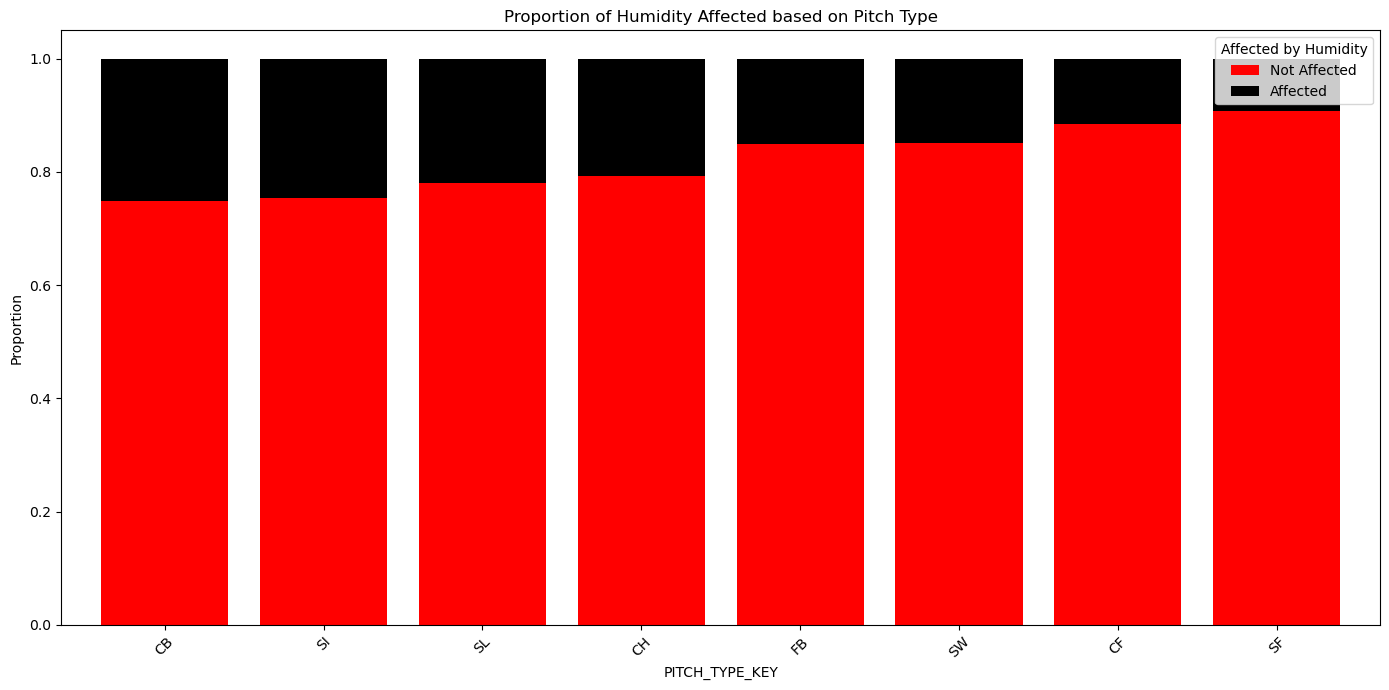

In [267]:
# Calculate the counts
pitch_type_counts = data_cleaned.groupby(['PITCH_TYPE_TRACKED_KEY', 'NAIVE_PREDICTION']).size().unstack()

# Calculate proportions
pitch_type_props = pitch_type_counts.divide(pitch_type_counts.sum(axis=1), axis=0)

sorted_pitch_type_props = pitch_type_props.sort_values(by=1, ascending=False)

# Plot the proportions using a stacked bar chart
plt.figure(figsize=(14, 7))
sorted_pitch_type_props.plot(kind='bar', stacked=True, colormap=custom_cmap, width=0.8, ax=plt.gca())
plt.title('Proportion of Humidity Affected based on Pitch Type')
plt.xlabel('PITCH_TYPE_KEY')
plt.ylabel('Proportion')
plt.legend(title='Affected by Humidity', labels=['Not Affected', 'Affected'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### It makes sense that pitches that rely heavily on spin and movement are the ones that have a higher proportion affected by humdity. Based on the proportion bar chart, curveballs, sinkers and sliders are the most affected by humidity. This fits with our previous hypothesis and is one indicator that our found probabilities are somewhat accurate. 



# 11. Next Steps

### Using the Naive Probabiilty and Naive Prediction variable, it would be good to look at which pitchers are most affected by humidity. We will only plot pitchers that have more than 400 pitches. 

### We will first look at the pitchers with the highest proportion of humidity affected pitches 

In [264]:
# get pitcher keys that have thrown more than 100 pitches
pitchers_with_more_than_400_pitches = data_cleaned['PITCHER_KEY'].value_counts()[data_cleaned['PITCHER_KEY'].value_counts() > 400].index
gt_400_Pitches = data_cleaned[data_cleaned['PITCHER_KEY'].isin(pitchers_with_more_than_400_pitches)]


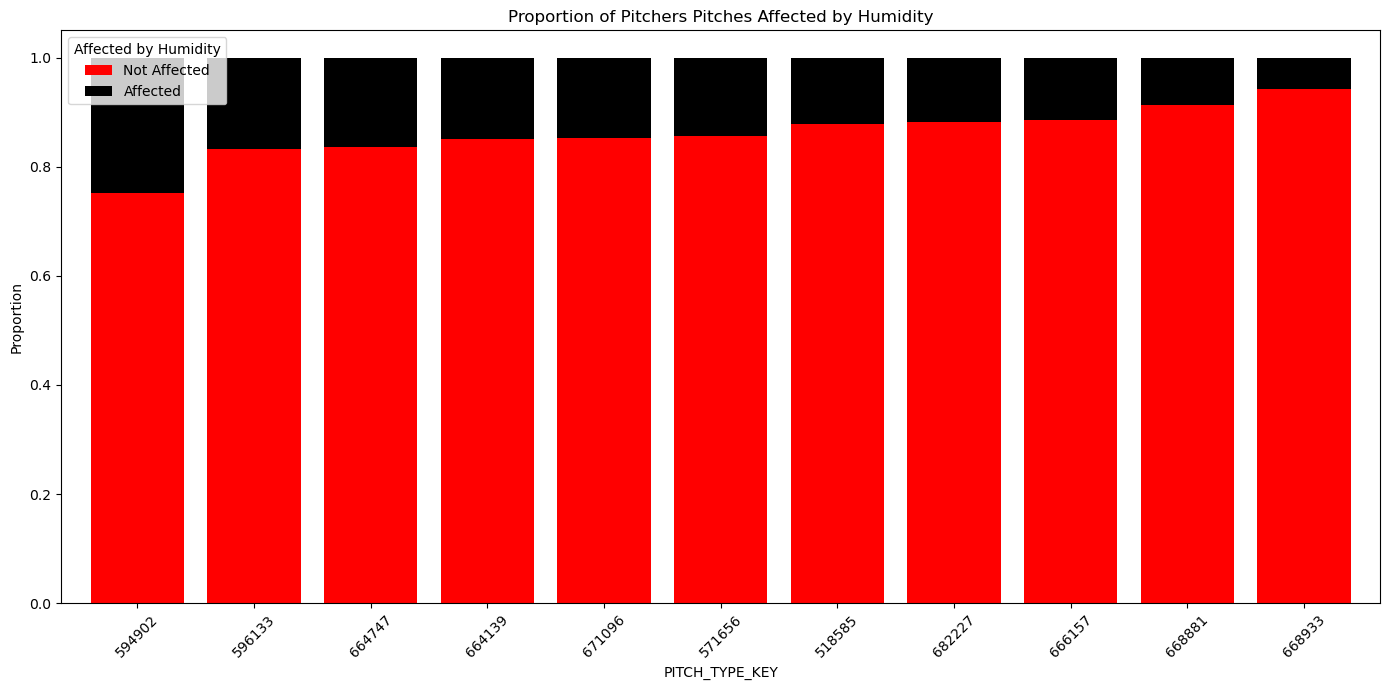

In [266]:
# Calculate the counts
pitcher_humidity_counts = gt_400_Pitches.groupby(['PITCHER_KEY', 'NAIVE_PREDICTION']).size().unstack()

# Calculate proportions
pitcher_props = pitcher_humidity_counts.divide(pitcher_humidity_counts.sum(axis=1), axis=0)

sorted_pitcher_props = pitcher_props.sort_values(by=1, ascending=False)

# Plot the proportions using a stacked bar chart
plt.figure(figsize=(14, 7))
sorted_pitcher_props.plot(kind='bar', stacked=True, colormap=custom_cmap, width=0.8, ax=plt.gca())
plt.title('Proportion of Pitchers Pitches Affected by Humidity')
plt.xlabel('PITCH_TYPE_KEY')
plt.ylabel('Proportion')
plt.legend(title='Affected by Humidity', labels=['Not Affected', 'Affected'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### We can see that pitcher 594902, 596133 ,and 664747 have the highest proporiton of humidity affected pitches. These would be the pitchers that we would either try to avoid having pitch in humid environments or work with them to improve in these environments 

### Finally, we can look distributions for affected and non affected pitches based on pitch speed

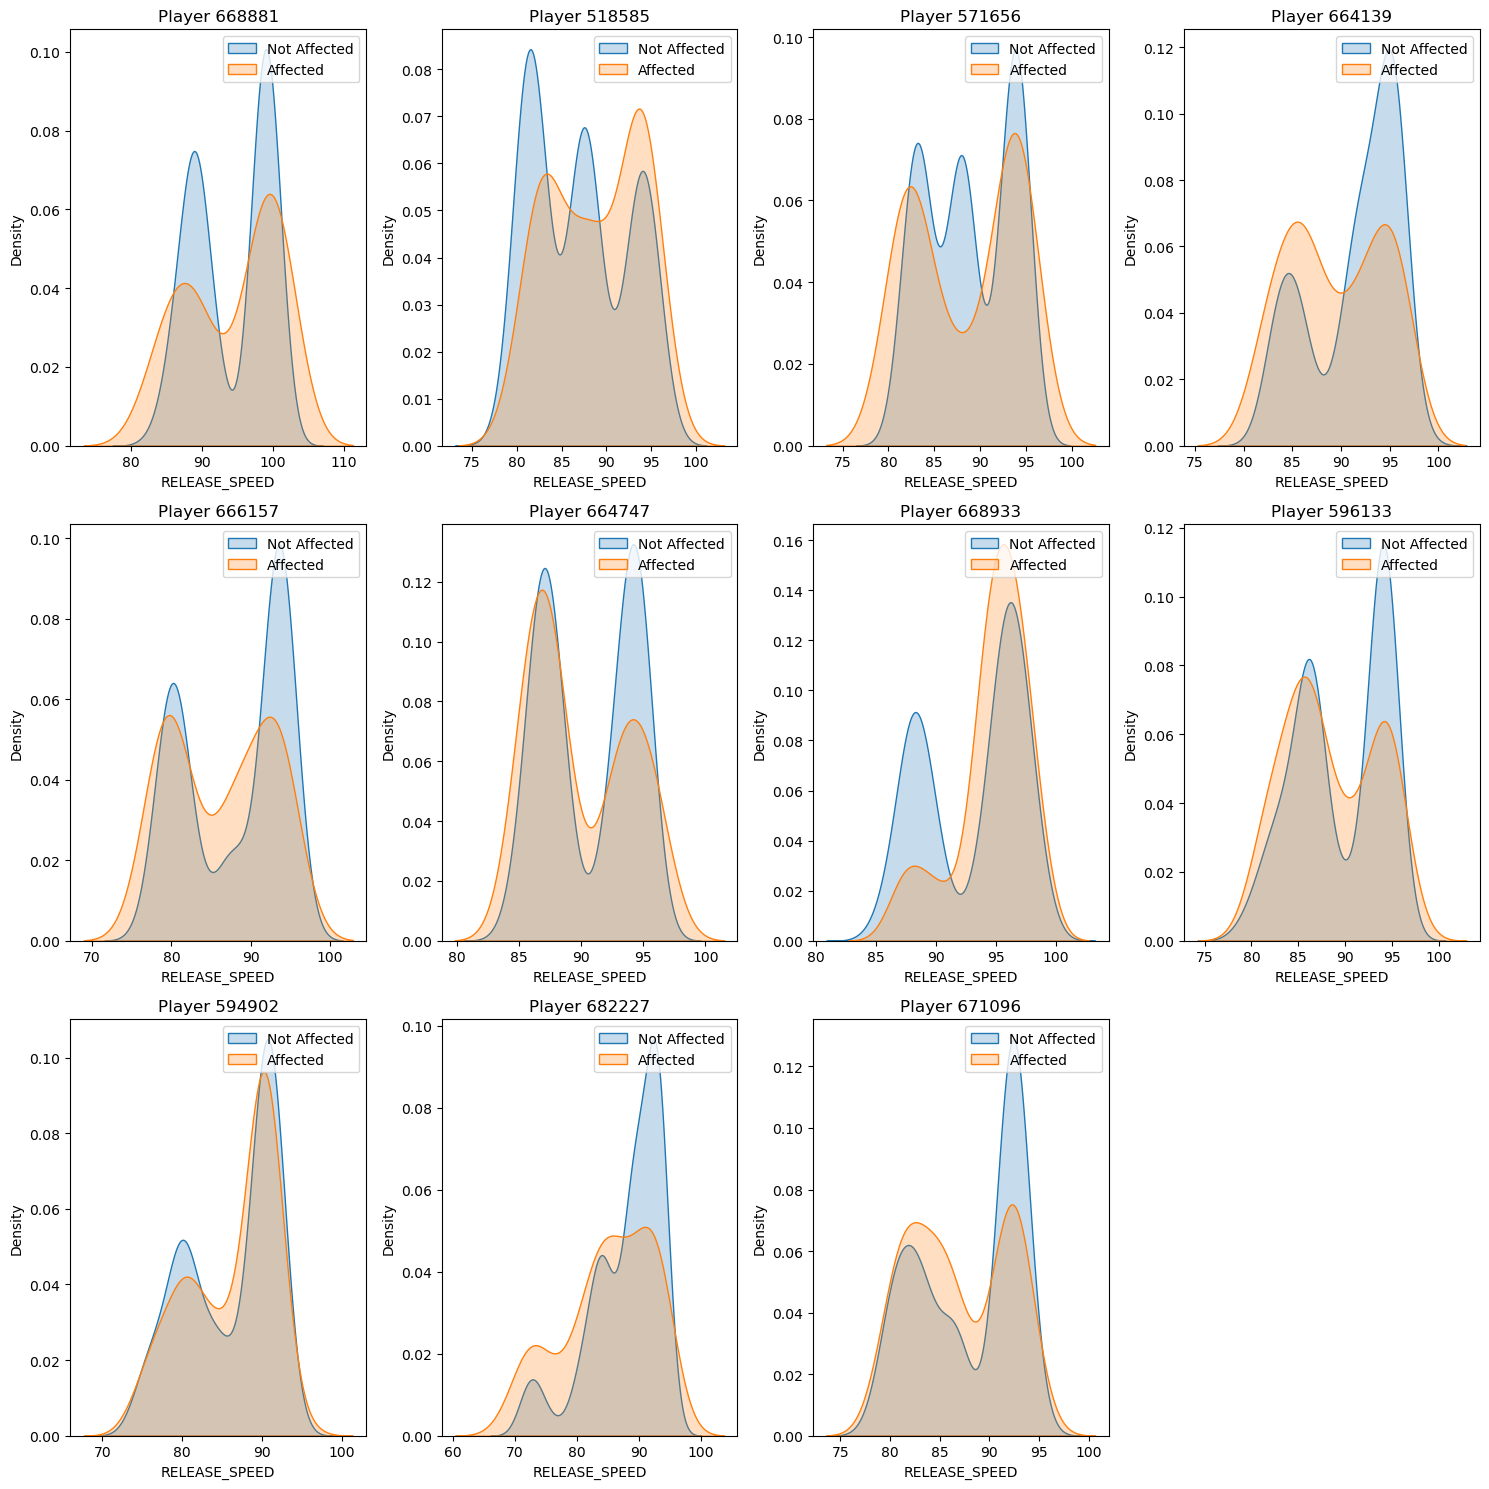

In [242]:
# Determine grid dimensions based on the number of players
grid_rows = int(len(players) ** 0.5)
grid_cols = len(players) // grid_rows + (len(players) % grid_rows > 0)

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 5 * grid_rows))
axes = axes.ravel()  # Flatten the grid to easily iterate over it

for idx, player in enumerate(players):
    player_data = data_cleaned[data_cleaned['PITCHER_KEY'] == player]
    sns.kdeplot(player_data[player_data['NAIVE_PREDICTION'] == 0]['RELEASE_SPEED'], label='Not Affected', shade=True, ax=axes[idx])
    sns.kdeplot(player_data[player_data['NAIVE_PREDICTION'] == 1]['RELEASE_SPEED'], label='Affected', shade=True, ax=axes[idx])
    axes[idx].set_title(f'Player {player}')
    axes[idx].set_xlabel('RELEASE_SPEED')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()

# Hide remaining empty subplots (if any)
for idx in range(len(players), grid_rows * grid_cols):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### We can see that some players have similar distributions for dewpoint affected pitches and non affected pitches based on pitch velocity. We can say that these players are not affected by dewpoint. The ones that we would like to flag for further investigation are the ones that have different distributions. An example of this would be pitcher 6643 who has a greater proportion of offspeed pitches that are affected by humidity and pitcher 518585 who has a greater proportion of fastballs that are affected by humidity. This would give us specific pitches to work on with specific players to help improve their performance. We could also tell these specific players to stop throwing as many fastballs/offspeed pitches during these starts. 

### NOTE: Given the nature of this problem, pitches affected by humidity are considered if spin rate and movement are either significantly larger or smaller than they typically are. In practice, we would only flag pitches for concern if their spin rate and movement were less than average. 

# 12. Conclusions

### Assumptions: any change in spin_rate/ movement is directly caused by dewpoint and not a result of a pitcher slipping or other circumstances. 

In [275]:
# deliverable = data_cleaned[['PID','NAIVE_PREDICTION']]
# all_pids = data[['PID']]

submission = data[['PID']].merge(data_cleaned[['PID','NAIVE_PREDICTION']], on='PID', how='left')
# Fill missing values in NAIVE_PREDICTION with 0
submission['NAIVE_PREDICTION'].fillna(0, inplace=True)

submission.to_csv('submission.csv')